# Flood Estimation/Extrapolation - REPORT

The idea of this notebook is to use the current RS detected flood and try to extrapolate it to the whole region, using a DEM.

It automates the creation of reports for each municipality.


In [1]:
%load_ext autoreload
%autoreload 2
import io
from pathlib import Path
import gc

import icloud
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from shapely.geometry import box
import rioxarray as xrio
import skimage
from PyPDF2 import PdfMerger, PdfReader, PdfWriter

from flood_processor import FloodProcessor
from utils import create_fname, decode_name, create_folder, flood_areas_hand

from tqdm.notebook import tqdm

## iCloud Access

All the 700 processed areas are already stored in iCloud, so we will connect to it in the first hand. 

In [2]:
if 'session' not in globals():
    session = icloud.icloud_login()

## Defs

In [3]:
# Threshold for the entire area in km2
TOTAL_FLOOD_THRESHOLD = 0.1  # eq 10 ha

# Threshold for each flood area in number of pixels (30x30)
LOCAL_FLOOD_THRESHOLD = 50 # eq. 4.5ha

DATA_FOLDER = Path('/data/flood_reports')

ICLOUD_FOLDER = 'sen1flood'


## Open the Summary Table

In [5]:
summary = pd.read_parquet("../data/summary.parquet")
summary.iloc[0:20][['municipio', 'uf', 'data', 'descricao_tipologia']]#.head(10)

municipio  uf       data descricao_tipologia
2              Rio do Sul  SC 2017-06-01          Inundações
7              Montenegro  RS 2016-10-19          Inundações
14             Uruguaiana  RS 2017-05-31          Inundações
22                Estrela  RS 2020-07-14          Inundações
30             Montenegro  RS 2020-07-15          Inundações
36        Eldorado do Sul  RS 2016-10-20          Inundações
37                Rolante  RS 2017-01-05          Enxurradas
38             Montenegro  RS 2017-05-24          Inundações
43             Roca Sales  RS 2020-07-11          Inundações
63                Brusque  SC 2017-01-05          Enxurradas
68   São Sebastião do Caí  RS 2020-07-11          Inundações
69   São Sebastião do Caí  RS 2016-10-18          Inundações
74                  Muçum  RS 2020-07-11          Inundações
77               Alegrete  RS 2017-04-11          Inundações
78     Presidente Getúlio  SC 2020-12-17          Enxurradas
80                Lajeado  RS 2020-07-16          Inundações
98        Eldorado do Sul  RS 2017-06-09          Inundações
101             Bombinhas  SC 2016-04-13          Enxurradas
102         Novo Hamburgo  RS 2019-03-09          Enxurradas
104          São Jerônimo  RS 2020-07-11          Inundações

## Main Loop

In [ ]:
# First, prepare the summary table to receive the new information
summary[['vulnerable_area', 'urban_area', 'urban_vulnerable', 'DEM-Status']] = None

# loop through the items
for idx, place in tqdm(summary.iterrows(), total=len(summary)):

    # create a processor for the item
    processor = FloodProcessor(place, '/data/flood_reports/', ICLOUD_FOLDER, '/data/anadem_pitless.tif', '/data/anadem_hand.tif')

    # save the variables locally
    processor.save_vars(['ref', 'dem', 'hand', 'max_flood', 'extrapolated_flood'])

    # create a Pdf merger and add the report
    merger = PdfMerger()
    merger.append(processor.report)

    # than add page 1
    page1 = processor.create_dem_page()
    merger.append(page1)

    # Check if page 2 is available
    page2 = None
    try:
        page2 = processor.create_flood_page()
        merger.append(page2)
    except:
        pass
    finally:
        merger.write(processor.report)

    summary.loc[idx] = processor.place  # type: ignore 
    
    summary.to_parquet("../data/summary.parquet")
    summary.to_csv("../data/summary.csv")

    del page1
    del page2
    del processor
    gc.collect()



In [7]:
summary

municipio  uf       data       ibge  \
2                     Rio do Sul  SC 2017-06-01  4214805.0   
7                     Montenegro  RS 2016-10-19  4312401.0   
14                    Uruguaiana  RS 2017-05-31  4322400.0   
22                       Estrela  RS 2020-07-14  4307807.0   
30                    Montenegro  RS 2020-07-15  4312401.0   
...                          ...  ..        ...        ...   
1178            São João Batista  SC 2016-03-01  4216305.0   
1179                    Botuverá  SC 2016-03-03  4202701.0   
1180                     Ibirama  SC 2016-03-03  4206900.0   
1181  Presidente Castello Branco  SC 2016-03-03  4213906.0   
1763                   Canelinha  SC 2020-12-24  4203709.0   

     descricao_tipologia                                          s3_dates  \
2             Inundações  [2017-05-13, 2017-05-25, 2017-06-06, 2017-06-18]   
7             Inundações  [2016-10-02, 2016-10-14, 2016-10-26, 2016-11-07]   
14            Inundações  [2017-05-21, 2017-05-28, 2017-06-02, 2017-06-09]   
22            Inundações  [2020-07-01, 2020-07-13, 2020-07-25, 2020-08-06]   
30            Inundações  [2020-07-01, 2020-07-13, 2020-07-25, 2020-08-06]   
...                  ...                                               ...   
1178          Enxurradas  [2016-02-06, 2016-02-18, 2016-03-01, 2016-03-25]   
1179          Enxurradas  [2016-02-18, 2016-03-01, 2016-03-25, 2016-04-06]   
1180          Enxurradas  [2016-02-18, 2016-03-01, 2016-03-25, 2016-04-06]   
1181          Enxurradas  [2016-01-30, 2016-02-23, 2016-03-18, 2016-03-30]   
1763          Enxurradas  [2020-12-11, 2020-12-23, 2021-01-04, 2021-01-16]   

              s3_deltas  water_baseline                     water_areas  \
2      [-19, -7, 5, 17]           1.018    [0.615, 0.485, 5.301, 0.522]   
7      [-17, -5, 7, 19]           0.796     [0.729, 0.827, 2.21, 0.508]   
14      [-10, -3, 2, 9]           6.109  [8.535, 10.912, 13.282, 8.699]   
22    [-13, -1, 11, 23]           2.839    [2.369, 2.857, 2.295, 2.642]   
30    [-14, -2, 10, 22]           0.781    [0.454, 4.827, 0.202, 0.489]   
...                 ...             ...                             ...   
1178  [-24, -12, 0, 24]           0.167    [0.132, 0.098, 0.122, 0.107]   
1179  [-14, -2, 22, 34]           0.295    [0.501, 0.584, 0.532, 0.644]   
1180  [-14, -2, 22, 34]           0.842    [0.167, 0.211, 0.175, 0.199]   
1181  [-33, -9, 15, 27]           0.000            [0.0, 0.0, 0.0, 0.0]   
1763  [-13, -1, 11, 23]           1.081     [0.923, 1.189, 0.878, 0.91]   

                      flooded_area                urban_flood  \
2       [0.007, 0.0, 4.358, 0.002]     [0.0, 0.0, 0.048, 0.0]   
7     [0.093, 0.245, 1.542, 0.006]       [0.0, 0.0, 0.0, 0.0]   
14     [2.318, 4.646, 6.99, 4.884]  [0.0, 0.001, 0.015, 0.01]   
22      [0.019, 0.236, 0.0, 0.009]     [0.0, 0.002, 0.0, 0.0]   
30    [0.033, 4.015, 0.003, 0.011]     [0.0, 0.004, 0.0, 0.0]   
...                            ...                        ...   
1178          [0.0, 0.0, 0.0, 0.0]       [0.0, 0.0, 0.0, 0.0]   
1179  [0.017, 0.019, 0.016, 0.058]       [0.0, 0.0, 0.0, 0.0]   
1180         [0.0, 0.01, 0.0, 0.0]       [0.0, 0.0, 0.0, 0.0]   
1181          [0.0, 0.0, 0.0, 0.0]       [0.0, 0.0, 0.0, 0.0]   
1763  [0.036, 0.128, 0.037, 0.043]       [0.0, 0.0, 0.0, 0.0]   

                                           status vulnerable_area urban_area  \
2                                          OK-Geo         33.6105    40.6521   
7                                          OK-Geo          18.585    23.0337   
14                                         OK-Geo         17.4807    33.7824   
22                                         OK-Geo          9.7488    17.1261   
30                                         OK-Geo         15.4764    23.0337   
...                                           ...             ...        ...   
1178  No flooded regions considering threshold=25            None       None   
1179  No flooded re

## Step by step

In [5]:
# idx = 368
idx = 36
place = summary.loc[idx]
place

municipio                                               Eldorado do Sul
uf                                                                   RS
data                                                2016-10-20 00:00:00
ibge                                                          4306767.0
descricao_tipologia                                          Inundações
s3_dates               [2016-10-02, 2016-10-14, 2016-10-26, 2016-11-07]
s3_deltas                                              [-18, -6, 6, 18]
water_baseline                                                  113.899
water_areas                         [162.318, 122.456, 143.36, 174.347]
flooded_area                           [51.956, 24.657, 70.059, 57.728]
urban_flood                                      [0.013, 0.0, 0.0, 0.0]
status                                                           OK-Geo
vulnerable_area                                                     NaN
urban_area                                                      

In [6]:
from flood_processor import FloodProcessor
processor = FloodProcessor(place, '/data/flood_reports/', ICLOUD_FOLDER, '/data/anadem_pitless.tif', '/data/anadem_hand.tif')
self = processor
processor

Flood Processor for place: 
municipio                                               Eldorado do Sul
uf                                                                   RS
data                                                2016-10-20 00:00:00
ibge                                                          4306767.0
descricao_tipologia                                          Inundações
s3_dates               [2016-10-02, 2016-10-14, 2016-10-26, 2016-11-07]
s3_deltas                                              [-18, -6, 6, 18]
water_baseline                                                  113.899
water_areas                         [162.318, 122.456, 143.36, 174.347]
flooded_area                           [51.956, 24.657, 70.059, 57.728]
urban_flood                                      [0.013, 0.0, 0.0, 0.0]
status                                                           OK-Geo
vulnerable_area                                                988.4331
urban_area                          

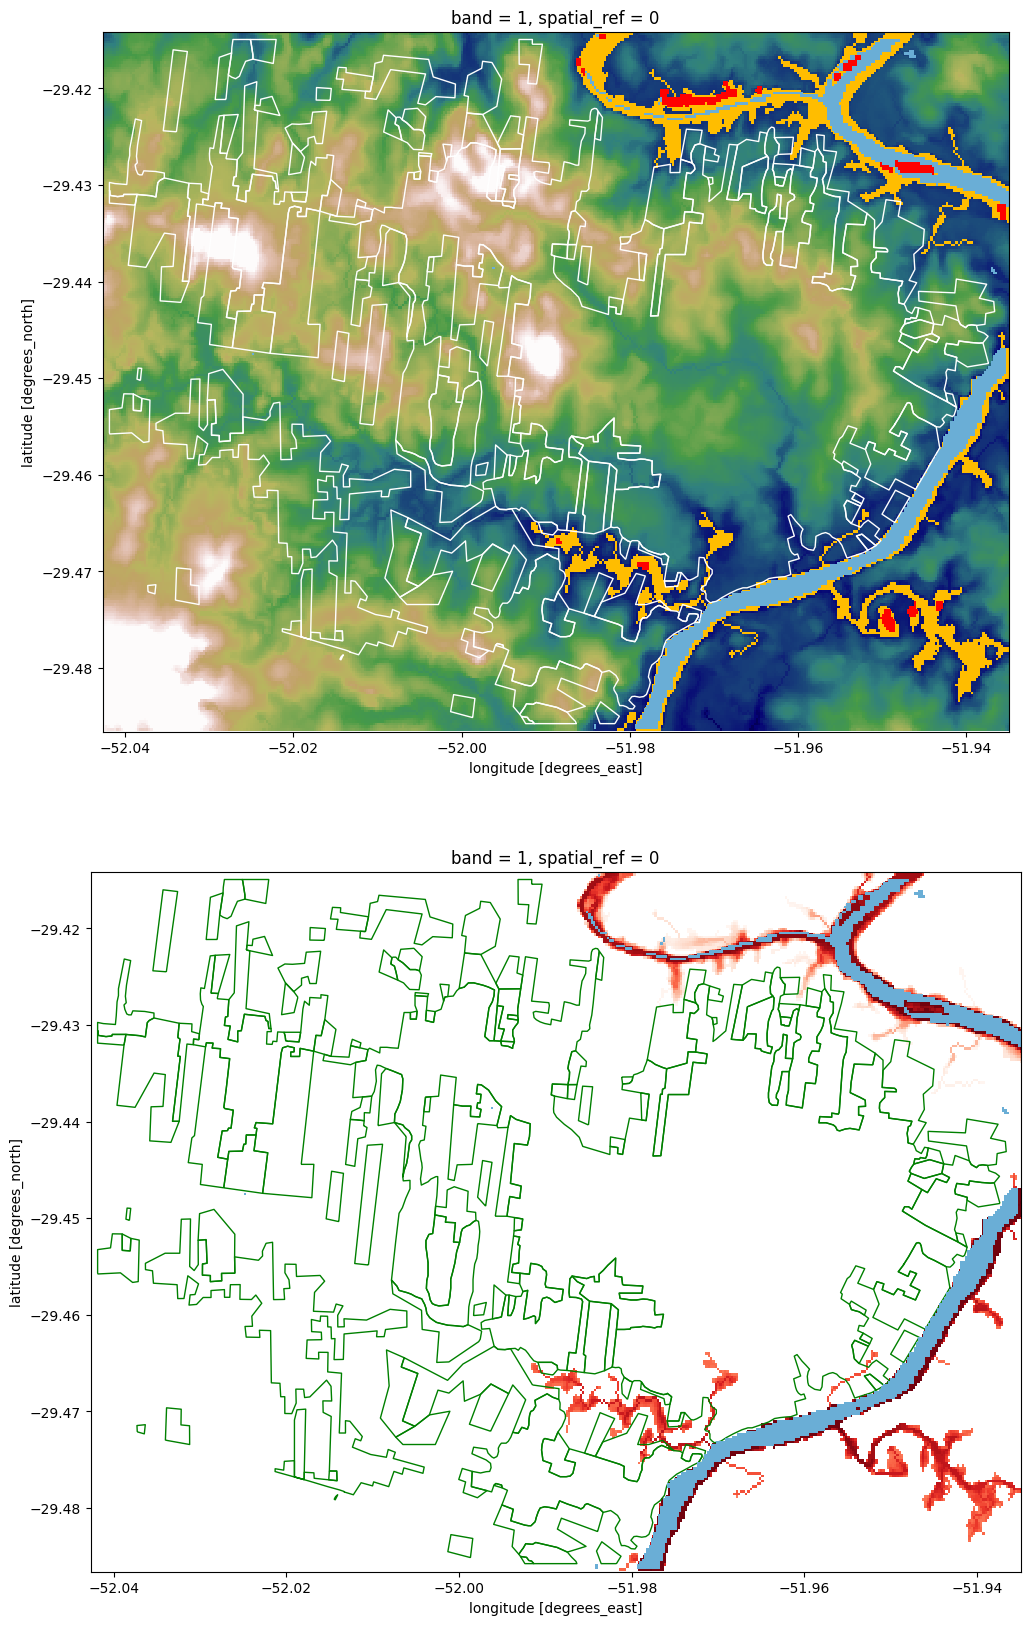

In [115]:
# vulnerable_area, urban_vulnerable, urban_area
processor.plot_flood_summary()

<Axes: >

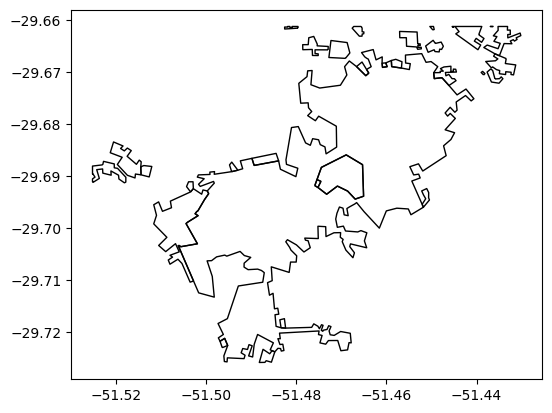

In [9]:
fig, ax = plt.subplots()
self['aoi'].plot(facecolor='none', ax=ax)

In [12]:
extrapolated_flood = self['ref'].copy()
extrapolated_flood.data = self['extrapolated_flood']

In [33]:
self.extrapolate_flood

<bound method FloodProcessor.extrapolate_flood of Flood Processor for place: 
municipio                                                    Montenegro
uf                                                                   RS
data                                                2016-10-19 00:00:00
ibge                                                          4312401.0
descricao_tipologia                                          Inundações
s3_dates               [2016-10-02, 2016-10-14, 2016-10-26, 2016-11-07]
s3_deltas                                              [-17, -5, 7, 19]
water_baseline                                                    0.796
water_areas                                 [0.729, 0.827, 2.21, 0.508]
flooded_area                               [0.093, 0.245, 1.542, 0.006]
urban_flood                                        [0.0, 0.0, 0.0, 0.0]
status                                                           OK-Geo
Name: 7, dtype: object>

In [23]:
urban_flood = extrapolated_flood.astype('float').rio.clip(self['aoi'].geometry, all_touched=True)
urban_flood = urban_flood.where(urban_flood != urban_flood.attrs['_FillValue'])
urban_flood

<xarray.DataArray 'ref' (y: 241, x: 354)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -51.53 -51.52 -51.52 ... -51.43 -51.43 -51.43
  * y            (y) float64 -29.66 -29.66 -29.66 ... -29.73 -29.73 -29.73
    band         int64 1
    spatial_ref  int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

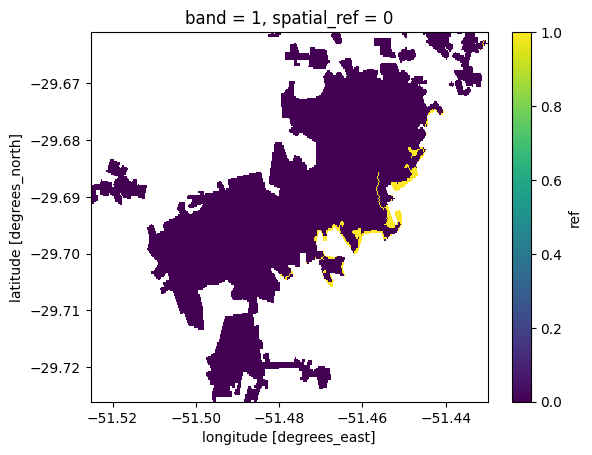

In [24]:
urban_flood.plot()

In [29]:
# calculate the urban area in km2
urban_area = urban_flood.count() * 30*30 *1e-6

In [56]:
# calculate the urban flood area in ha
urban_flood_area = urban_flood.where(urban_flood>0).count() * 30 * 30 * 1e-6
float(urban_flood_area)

0.5643

In [26]:
urban_flood.shape

(241, 354)

In [27]:
241*354

85314

In [41]:
flooded_regions, labels, dem_steps, hand_height = processor.extrapolate_flood()

In [59]:
floods = np.stack(flooded_regions)
extrapolated_flood = floods.any(axis=0)#.astype('float')

In [101]:
extrapolated_flood

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [92]:
extrapolated_flood[extrapolated_flood == 0] = np.nan

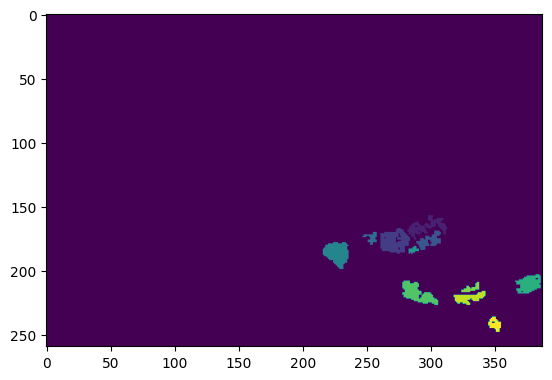

In [44]:
plt.imshow(labels)

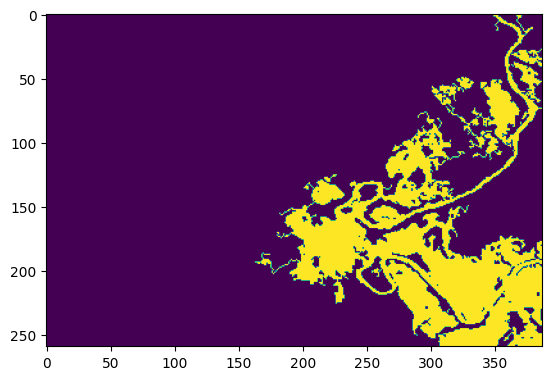

In [57]:
plt.imshow(flooded_regions[1])

In [54]:
hand_height

0.4847358465194702

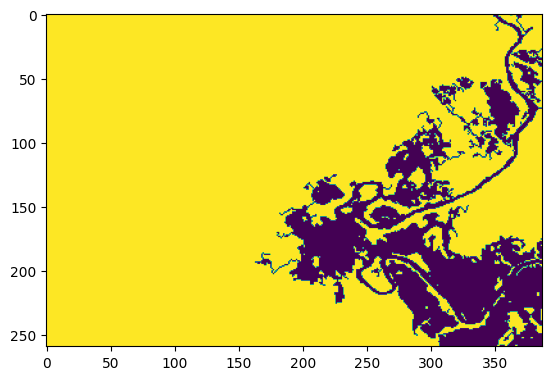

In [55]:
plt.imshow(dem_steps[1])

In [29]:
flood_mask = np.nan_to_num(flood_mask, nan=0)

In [32]:
flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=10)

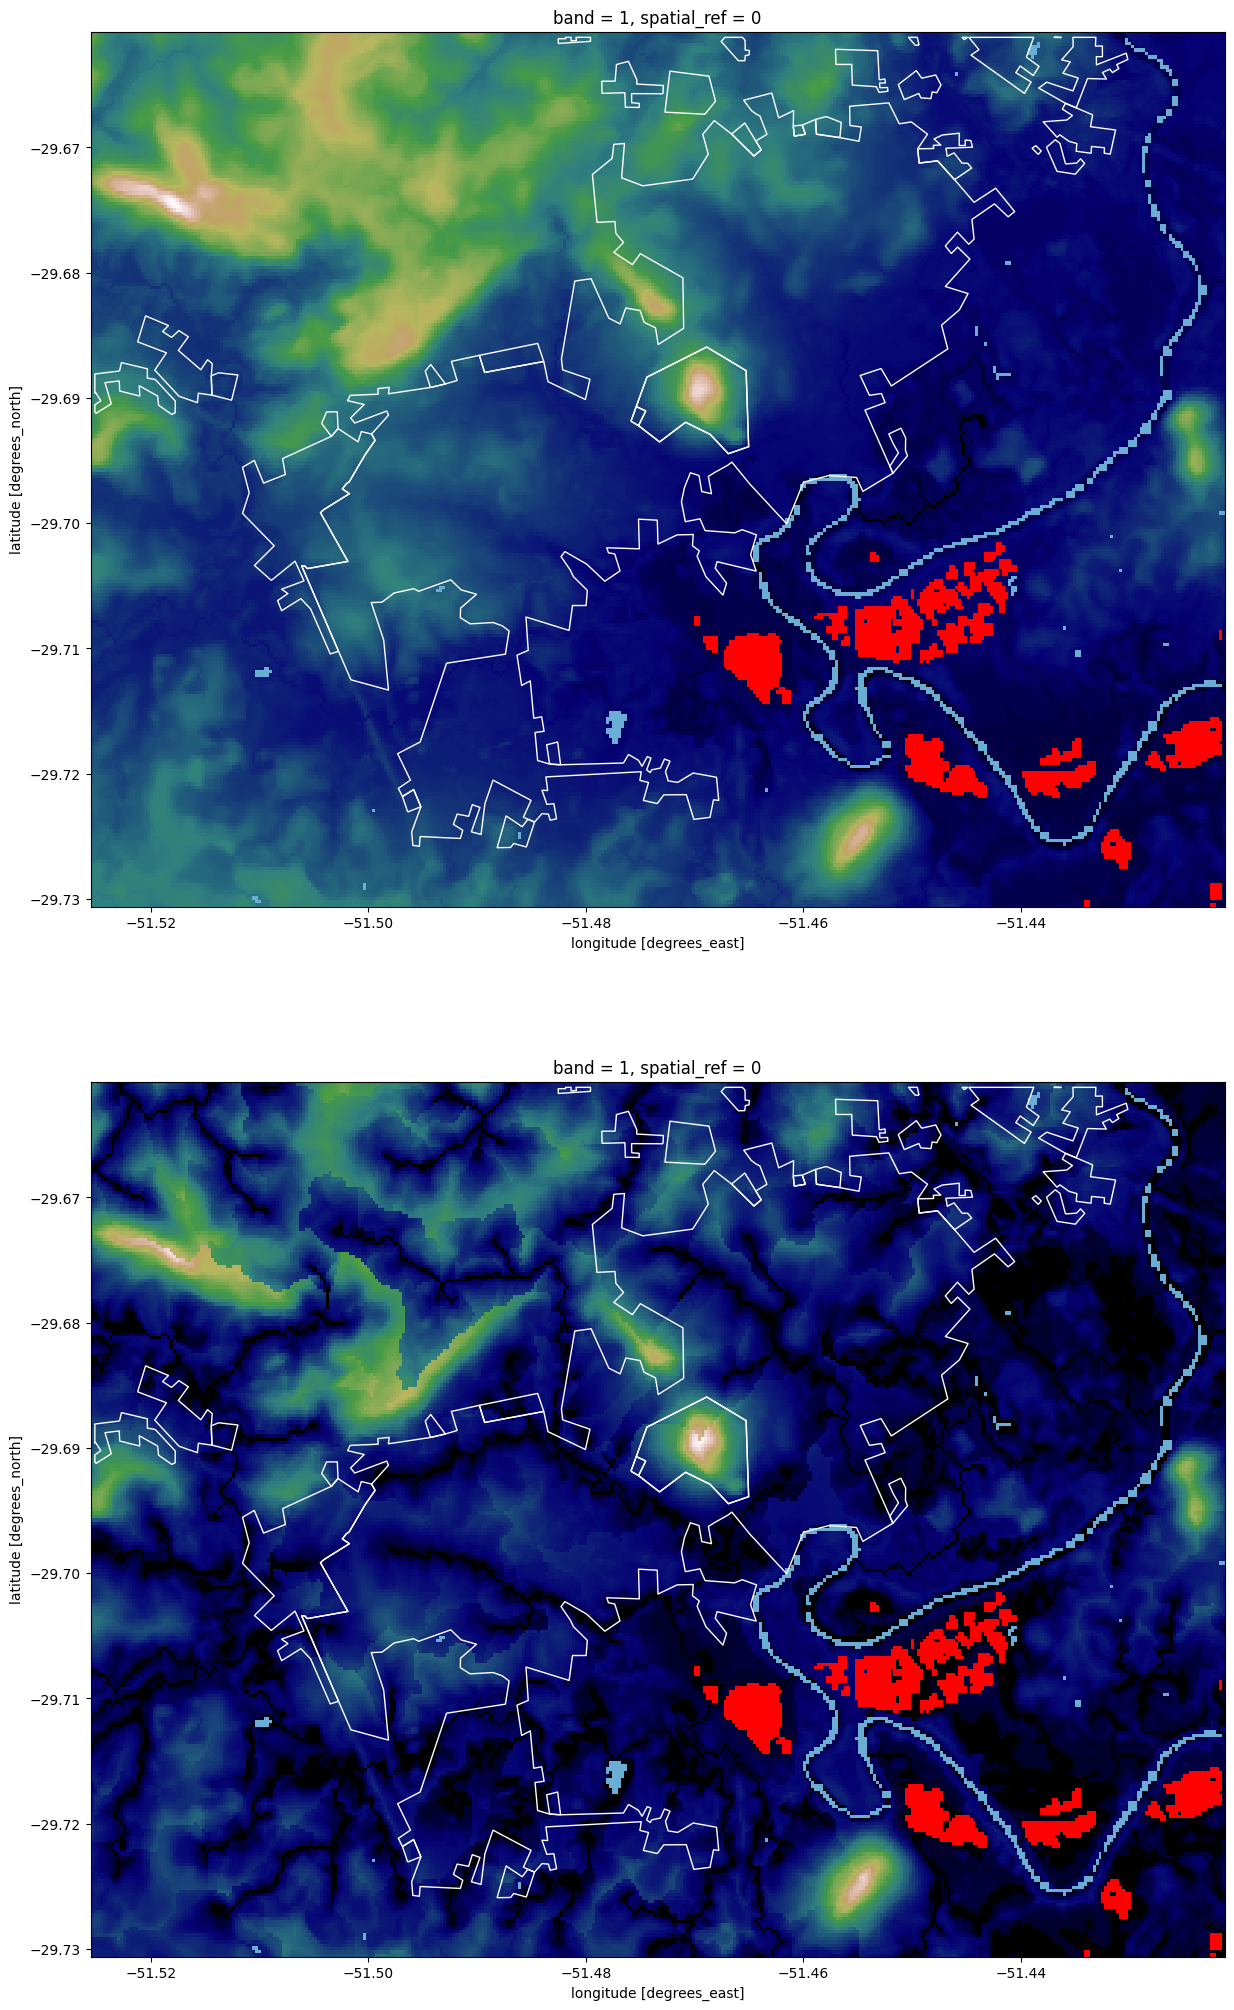

In [116]:
fig2, ax = plt.subplots(2, 1, figsize=(15, 25), num=1)
processor.plot_vars(ax=ax[0])

processor.plot_vars(ax=ax[1], dem='hand')


In [129]:
self = processor

In [138]:
fig2, axs = plt.subplots(2, 1, figsize=(15, 25), num=1)

ax = axs[1]
processor.plot_var('aoi', ax=ax, facecolor='none', edgecolor='green')
extrapolated_flood = floods.any(axis=0)#.astype('float')
extrapolated_flood = processor['dem'].where(extrapolated_flood).copy()
extrapolated_flood.plot.imshow(ax=ax, vmin=0, cmap='Reds_r', add_colorbar=False)
processor.plot_var('ref', ax=ax, cmap='Blues', vmax=1, add_colorbar=False)
# extrapolated_flood[~ extrapolated_flood] = np.nan
# ax[1].imshow(extrapolated_flood, zorder=1000)

ax = axs[0]
self.plot_var('dem', ax=ax, cmap="gist_earth", vmin=0, add_colorbar=False)

vulnerable_area = extrapolated_flood.copy()
vulnerable_area.data[~vulnerable_area.isnull()] = 1
vulnerable_area.plot(ax=ax, cmap='Wistia', add_colorbar=False)
self.plot_var("max_flood", vmax=1, cmap="brg", ax=ax, add_colorbar=False)
self.plot_var("ref", vmax=1, cmap="Blues", ax=ax, add_colorbar=False)
self.plot_var("aoi", facecolor="none", edgecolor="white", ax=ax)


In [139]:
page = processor.create_flood_page()

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


In [140]:
with open('test2.pdf', 'wb') as file:
    file.write(page.read())

In [70]:
ax[1].imshow(extrapolated_flood.astype('int'), zorder=1)

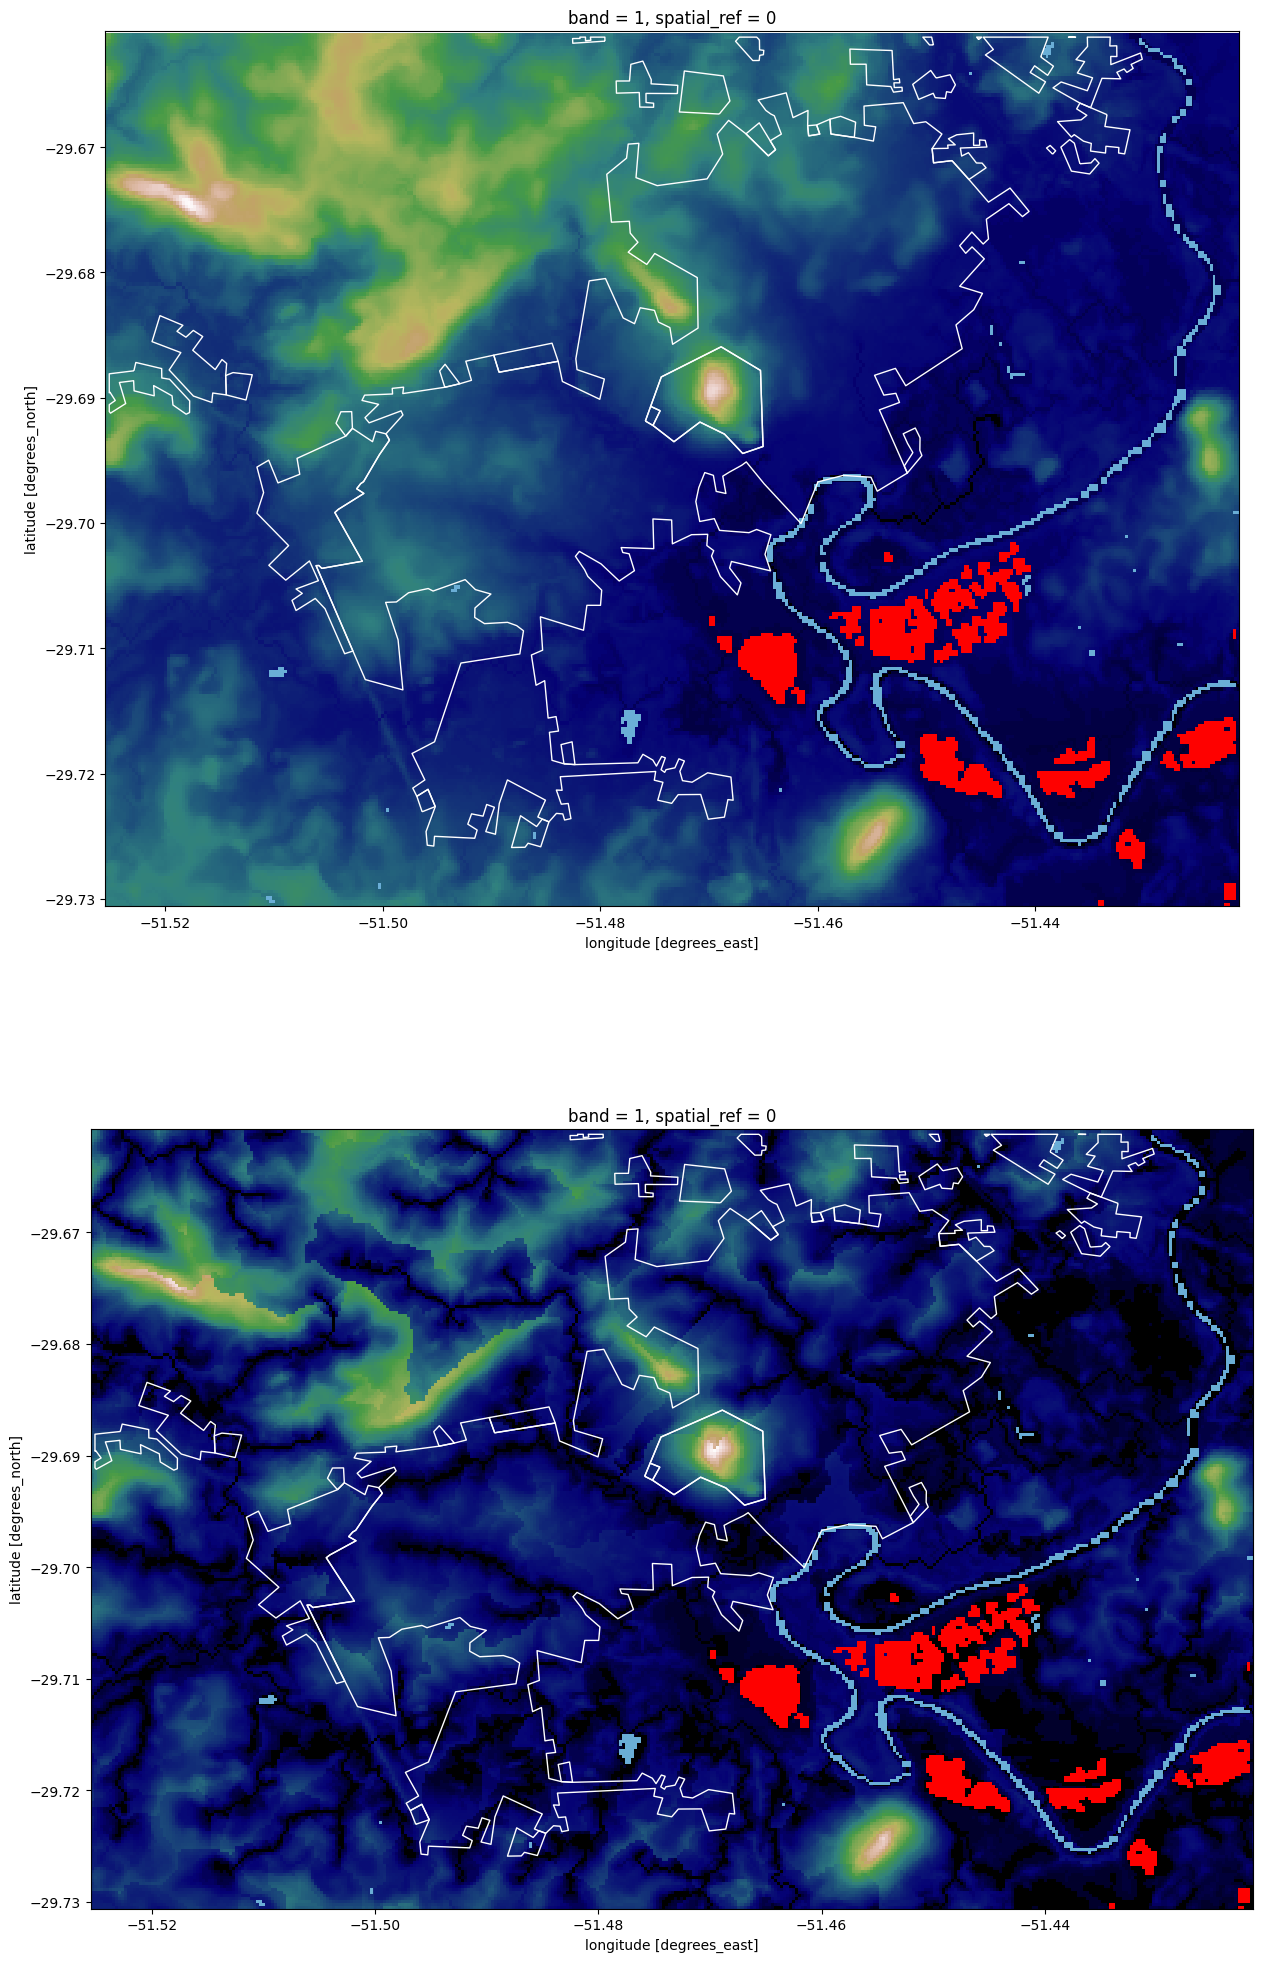

In [71]:
fig2

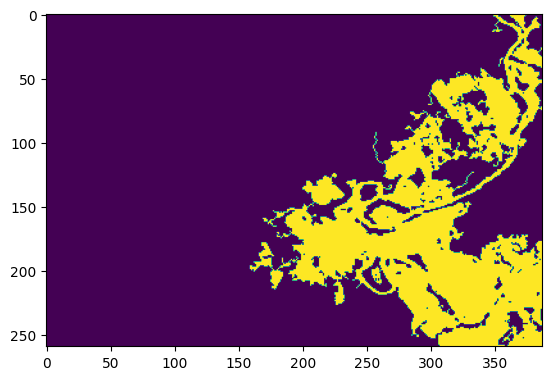

In [67]:
plt.imshow(extrapolated_flood)

In [24]:

# get the report to append new pages
pdf = icloud.get_report(session.drive[ICLOUD_FOLDER]['reports'], place, place_folder.as_posix())
merger = PdfMerger()
merger.append(pdf)

# create a page with the DEM and the HAND
fig, ax = plt.subplots(2, 1, figsize=(15, 25), num=1)

anadem.plot.imshow(ax=ax[0], robust=True)
max_flood.where(max_flood.data>0).plot.imshow(ax=ax[0], cmap='Reds', add_colorbar=False)
aoi.plot(ax=ax[0], facecolor='none', edgecolor='white')
ax[0].set_title('ANADEM model')

hand.plot.imshow(ax=ax[1], robust=True)
max_flood.where(max_flood.data>0).plot.imshow(ax=ax[1], cmap='Reds', add_colorbar=False)
aoi.plot(ax=ax[1], facecolor='none', edgecolor='white')
ax[1].set_title('ANADEM-HAND model')

page1 = io.BytesIO()
fig.savefig(page1, dpi=250, format='pdf')
page1.seek(0)
merger.append(page1)
fig.clear()


# skip analysis if the there is no flood 
if (place['flooded_area'] is not None) and (place['flooded_area'].max() >= TOTAL_FLOOD_THRESHOLD):
    
    # to proceed the analysis, we need every layer in the same shape
    max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326', shape=anadem.shape)

    try:
        flooded_regions, labels, dem_steps, hand_height = flood_areas_hand(max_flood.data, anadem.data, hand.data.squeeze(), threshold=LOCAL_FLOOD_THRESHOLD)
        # create final mask
        # concatenate the floods into a cube
        floods_cube = np.stack(flooded_regions)

        extrapolated_flood = max_flood.copy()
        extrapolated_flood.data = floods_cube.any(axis=0)

        extrapolated_flood.astype('int').rio.to_raster(place_folder/(place_folder.name + '_extrapolated.tif'))



    except Exception as e:
        # if something wrong occurs, reset the extrapolated flood to the original max_flood
        extrapolated_flood = max_flood.copy()
        labels = skimage.measure.label(max_flood.data)
        print(e)
        print(f"Error calculating extrapolated flood area for {idx}:{place['municipio']}")

    finally:
        fig, ax = plt.subplots(num=1, figsize=(12, 8))
        aoi.plot(ax=ax, zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
        anadem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
        # dem.where(dem < flood_height).plot(zorder=0)
        labels_spatial = anadem.copy()
        labels_spatial.data = labels > 0

        labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', 
                                                                        vmax=1, add_colorbar=False)
        
        page2 = io.BytesIO()
        fig.savefig(page2, dpi=250, format='pdf')
        page1.seek(0)
        merger.append(page2)
        fig.clear()
    

# save the new, updated report
merger.write(place_folder/('Report_' + place_folder.name + '.pdf'))

<Figure size 1500x2500 with 0 Axes>

In [25]:
place

municipio                                                    Agrolândia
uf                                                                   SC
data                                                2019-03-06 00:00:00
ibge                                                          4200200.0
descricao_tipologia                                          Enxurradas
s3_dates               [2019-02-20, 2019-03-04, 2019-03-16, 2019-03-28]
s3_deltas                                             [-14, -2, 10, 22]
water_baseline                                                    0.056
water_areas                                [0.063, 0.148, 0.119, 0.128]
flooded_area                                     [0.0, 0.004, 0.0, 0.0]
urban_flood                                        [0.0, 0.0, 0.0, 0.0]
status                                                           OK-Geo
Name: 368, dtype: object

## Main Loop

In the main loop we iterate through each municipality, but we will skip those without flood detected.

The flooded area is expressed in squared km. The .1km2 threshold is equivalent to 100ha. 


In [7]:
for idx, place in tqdm(summary.iterrows(), total=len(summary)):
    
    # organize one folder for each occurrence
    place_folder = DATA_FOLDER/create_fname(place)
    place_folder.mkdir(parents=True, exist_ok=True)

    # get AOI
    aoi = icloud.get_aoi(session.drive[ICLOUD_FOLDER]['vectors'], place, place_folder.as_posix())

    # get Floods and Reference water from pekel
    floods = icloud.get_flood(session.drive[ICLOUD_FOLDER]['rasters'], place, place_folder.as_posix())    
    ref = floods['ref']
    ref.astype('int').rio.to_raster(place_folder/(place_folder.name + '_ref.tif'))

    # create a series with the flood extension
    floods_series = floods.drop('ref').to_array(dim='layer').sum(dim=['x', 'y']).to_series()
    max_flood = floods[floods_series.idxmax()]
    max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326') #, shape=dem.shape)

    max_flood.rio.to_raster(place_folder/(place_folder.name + '_max_flood.tif'))

    # get the bounding box considering the maximum flood
    xmin, ymin, xmax, ymax = max_flood.rio.bounds()

    # load the DEM (ANADEM)
    anadem = xrio.open_rasterio('/data/anadem_pitless.tif').squeeze()
    anadem = anadem.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
    hand = xrio.open_rasterio('/data/anadem_hand.tif').squeeze()
    hand = hand.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))    

    # get the report to append new pages
    pdf = icloud.get_report(session.drive[ICLOUD_FOLDER]['reports'], place, place_folder.as_posix())
    merger = PdfMerger()
    merger.append(pdf)

    # create a page with the DEM and the HAND
    fig, ax = plt.subplots(num=1, 2, 1, figsize=(15, 25))

    anadem.plot.imshow(ax=ax[0], robust=True)
    max_flood.where(max_flood.data>0).plot.imshow(ax=ax[0], cmap='Reds', add_colorbar=False)
    aoi.plot(ax=ax[0], facecolor='none', edgecolor='white')
    ax[0].set_title('ANADEM model')

    hand.plot.imshow(ax=ax[1], robust=True)
    max_flood.where(max_flood.data>0).plot.imshow(ax=ax[1], cmap='Reds', add_colorbar=False)
    aoi.plot(ax=ax[1], facecolor='none', edgecolor='white')
    ax[1].set_title('ANADEM-HAND model')

    page1 = io.BytesIO()
    fig.savefig(page1, dpi=250, format='pdf')
    page1.seek(0)
    merger.append(page1)
    fig.clear()


    # skip analysis if the there is no flood 
    if (place['flooded_area'] is not None) and (place['flooded_area'].max() >= TOTAL_FLOOD_THRESHOLD):
        
        # to proceed the analysis, we need every layer in the same shape
        max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326', shape=anadem.shape)

        try:
            flooded_regions, labels, dem_steps, hand_height = flood_areas_hand(max_flood.data, anadem.data, hand.data.squeeze(), threshold=LOCAL_FLOOD_THRESHOLD)
            # create final mask
            # concatenate the floods into a cube
            floods_cube = np.stack(flooded_regions)

            extrapolated_flood = max_flood.copy()
            extrapolated_flood.data = floods_cube.any(axis=0)

            extrapolated_flood.astype('int').rio.to_raster(place_folder/(place_folder.name + '_extrapolated.tif'))



        except Exception as e:
            # if something wrong occurs, reset the extrapolated flood to the original max_flood
            extrapolated_flood = max_flood.copy()
            labels = skimage.measure.label(max_flood.data)
            print(e)
            print(f"Error calculating extrapolated flood area for {idx}:{place['municipio']}")

        finally:
            fig, ax = plt.subplots(num=1, figsize=(12, 8))
            aoi.plot(ax=ax, zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
            anadem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
            # dem.where(dem < flood_height).plot(zorder=0)
            labels_spatial = anadem.copy()
            labels_spatial.data = labels > 0

            labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', 
                                                                          vmax=1, add_colorbar=False)
            
            page2 = io.BytesIO()
            fig.savefig(page2, dpi=250, format='pdf')
            page1.seek(0)
            merger.append(page2)
            fig.clear()
        

    # save the new, updated report
    merger.write(place_folder/('Report_' + place_folder.name + '.pdf'))
    

  0%|          | 0/721 [00:00<?, ?it/s]

/tmp/ipykernel_24895/4212218457.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(15, 25))


local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 187:Florianópolis
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 212:Dom Pedrito
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 233:São Sebastião do Caí
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 252:São Jerônimo
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 253:Trombudo Central
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 265:Cachoeira do Sul
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 289:Agronômica
local variable 'hand_height' referenced before assignment
Error calculating extrapolated flood area for 300:Alegrete
local variable 'hand_h

In [6]:
def flood_areas_hand(flood_mask, dem, hand, threshold=50):
    """Extrapolate the obtained flood mask according to the DEM and HAND of the area"""

    # first, we clean the area by removing very small regions
    flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=threshold)

    # isolate all the identified flood areas
    labels = skimage.measure.label(flood_mask)
    # print(f'Number of areas to flood: {labels.max()}')

    # create lists to store the floods for each label and the dem region for each label
    floods = []
    dem_steps = []

    # let's loop through each label (i.e., flood region)
    for label in range(1, labels.max()+1):
        # print(f'Processing label {label}')

        # get the flood for the corresponding label (area)
        # and set all other pixels to 0
        flood_step = labels.copy()
        flood_step[labels!=label] = 0

        # get the highest pixel within the area, but try to remove any outlier
        height = np.percentile(dem[labels==label], 95)
        # height = dem[labels==label].max()
        # print(f'Height={height}')

        # create a the DEM-fences with the calculated height
        # this guarantees the flood fill will not go uphill and will not cross boundaries
        dem_step = dem.copy()
        dem_step[dem_step<=height] = 0
        dem_step[dem_step>height] = 1


        # the problem with the last assumption is that the river goes down so the farthest from the fill point
        # a bigger area will be flooded. In this case, we add a second assumption considering the HAND value
        hand_height = np.percentile(hand[labels==label], 95)
        if not np.isnan(hand_height):

            # print(f'Hand height = {hand_height}')
            # dem_step[hand <= hand_height] = 0
            dem_step[hand > hand_height] = 1

            dem_steps.append(dem_step)

            # to flood-fill, we need a starting point, we can get the lowest point with the label
            xs, ys = np.where(labels==label)
            pos = dem[xs, ys].argmin()
            start = (xs[pos], ys[pos])

            # flood fill and get the extended flood for this label
            flood = skimage.morphology.flood_fill(dem_step, seed_point=start, new_value=-1)
            flood = np.where(flood==-1, 1, 0)

        else:
            print(f'No hand available')
            flood = np.where(labels == label, 1, 0)
            dem_steps.append(flood)

        floods.append(flood)

    return floods, labels, dem_steps, hand_height

## Get the Vector (AOI)

Instead of getting the vector from the urban areas shape, we are retrieving exactly the vector that has been used to create the report. These vectors are saved in `onedrive` folder.

<Axes: >

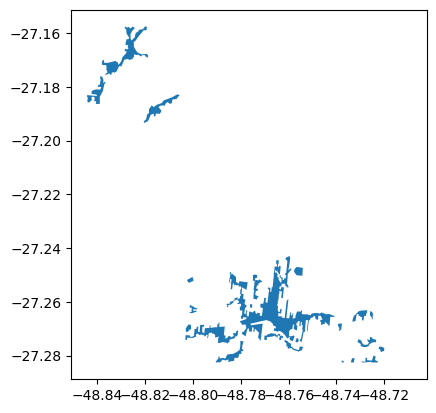

In [20]:
ICLOUD_FOLDER = 'sen1flood'

aoi = icloud.get_aoi(session.drive[ICLOUD_FOLDER]['vectors'], place, '/data/tmp')
aoi.plot()

## Get the Floods for the AOI

In [21]:
floods = icloud.get_flood(session.drive[ICLOUD_FOLDER]['rasters'], place, '/data/tmp')
floods

<xarray.Dataset>
Dimensions:                        (x: 1998, y: 1506)
Coordinates:
    band                           int64 1
  * x                              (x) float64 7.089e+05 7.09e+05 ... 7.289e+05
  * y                              (y) float64 6.995e+06 6.995e+06 ... 6.98e+06
    spatial_ref                    int64 0
Data variables:
    2020-12-11T08:39:50.790438500  (y, x) bool False False False ... False False
    2020-12-23T08:39:50.140840500  (y, x) bool False False False ... False False
    2021-01-04T08:39:49.619579000  (y, x) bool False False False ... False False
    2021-01-16T08:39:49.141418500  (y, x) bool False False False ... False False
    ref                            (y, x) bool False False False ... False False

In [22]:
floods_series = floods.drop('ref').to_array(dim='layer').sum(dim=['x', 'y']).to_series()
floods_series

layer
2020-12-11T08:39:50.790438500     358
2020-12-23T08:39:50.140840500    1278
2021-01-04T08:39:49.619579000     375
2021-01-16T08:39:49.141418500     427
dtype: int64

In [23]:
max_flood = floods[floods_series.idxmax()]

In [24]:
max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326') #, shape=dem.shape)

In [25]:
max_flood

<xarray.DataArray '2020-12-23T08:39:50.140840500' (y: 1428, x: 2098)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 -48.89 -48.89 -48.89 ... -48.69 -48.69 -48.69
  * y            (y) float64 -27.15 -27.15 -27.15 ... -27.29 -27.29 -27.29
    band         int64 1
    spatial_ref  int64 0

## Load the DEM

To load the DEM for the region, we are going to use the fabdem-brazil-south project, available on github: https://github.com/cordmaur/fabdem-brazil-south

In [26]:
import pystac
from shapely.geometry import box
from utils import search_catalog
import stackstac
from tqdm.notebook import tqdm

In [27]:
# open the catalog
if not 'fabdem_catalog' in globals():
    fabdem_catalog = pystac.Catalog.from_file(href='https://github.com/cordmaur/fabdem-brazil-south/raw/main/stac_catalog/catalog.json')

    for item in tqdm(fabdem_catalog.get_all_items()):
        pass

0it [00:00, ?it/s]

In [28]:
# get the bounding box considering the maximum flood
from shapely.geometry import box

bbox = box(*max_flood.rio.bounds())

items = search_catalog(fabdem_catalog, bbox.buffer(0.01))
items

[<Item id=S028W049_FABDEM_V1-2>]

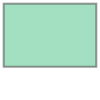

In [90]:
bbox

In [29]:
# create a cube with the items stacked
cube = stackstac.stack(
    items=items,
    bounds_latlon=bbox.bounds
)

cube

/usr/local/lib/python3.10/dist-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-3f429a5b3bc3d13a6c5d725c1a6a94c8' (time: 1,
                                                                band: 1,
                                                                y: 501, x: 736)>
dask.array<fetch_raster_window, shape=(1, 1, 501, 736), dtype=float64, chunksize=(1, 1, 501, 736), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) datetime64[ns] 2023-10-24T19:59:27.803024
    id              (time) <U20 'S028W049_FABDEM_V1-2'
  * band            (band) <U3 'DEM'
  * x               (x) float64 -48.89 -48.89 -48.89 ... -48.69 -48.69 -48.69
  * y               (y) float64 -27.15 -27.15 -27.15 ... -27.29 -27.29 -27.29
    tile_name       <U8 'S028W049'
    ...              ...
    proj:epsg       int64 4326
    proj:transform  object {0.0, -0.0002777777777777778, -26.999861111111112,...
    title           <U6 'fabdem'
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-49.0, -28.0...
    proj:bbox       object {-48.0, -28.0, -27.0, -49.0}
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-48.891666666666666, -27.28583...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-48.89|\n| 0.00,-0.00,-27.15|\n| 0.00, 0.00, 1.00|
    resolution:  0.0002777777777777778

In [30]:
dem = cube.mean(dim='time').squeeze().compute()


In [31]:
# dem.rio.to_raster('/data/tmp/dem.tif')

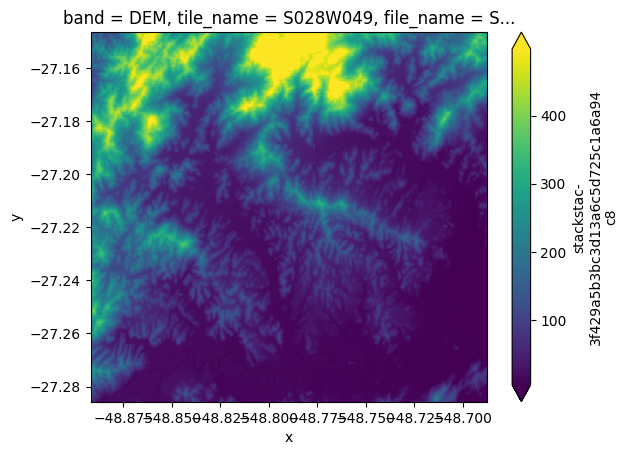

In [32]:
dem.plot.imshow(robust=True)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

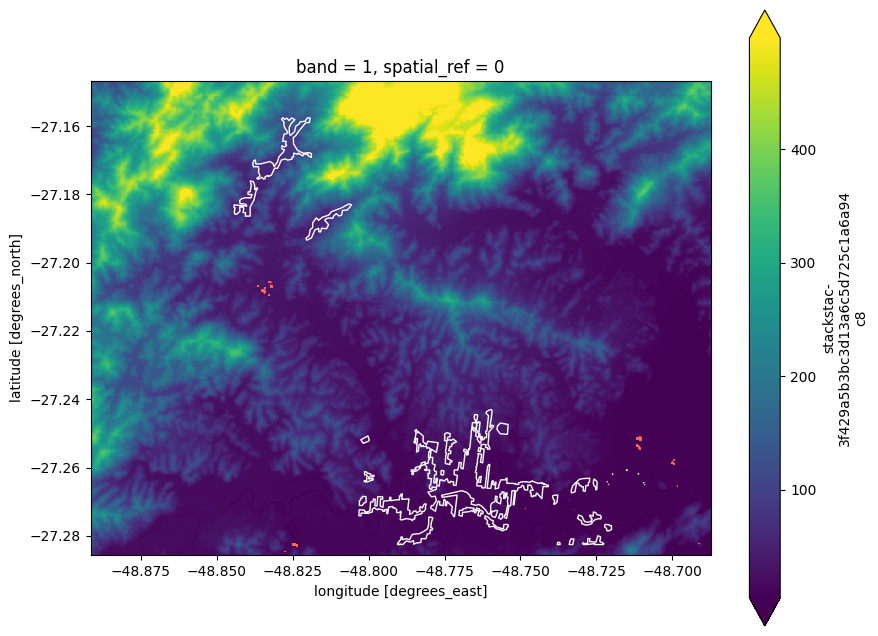

In [33]:
# plot the region
fig, ax = plt.subplots(figsize=(10, 8))
dem.plot.imshow(ax=ax, robust=True, add_colorbar=True) #type: ignore

max_flood.where(max_flood == 1).plot.imshow(ax=ax, add_colorbar=False, zorder=0, cmap='Reds')
aoi.plot(ax=ax, facecolor='none', edgecolor='white', zorder=1)


In [19]:
dem

<xarray.DataArray 'stackstac-9d84856c485329b3034aa7906b61e41d' (y: 285, x: 423)>
array([[69.34999847, 68.08999634, 67.98999786, ..., 75.04000092,
        75.30000305, 75.16999817],
       [69.76000214, 68.61000061, 68.08000183, ..., 71.5       ,
        74.34999847, 76.5       ],
       [69.48000336, 68.68000031, 68.41999817, ..., 70.38999939,
        70.58000183, 74.30999756],
       ...,
       [67.27999878, 66.69999695, 65.65000153, ..., 47.11000061,
        52.29000092, 55.29000092],
       [59.54999924, 60.20000076, 57.97999954, ..., 47.15999985,
        51.52000046, 54.70999908],
       [49.45000076, 50.31999969, 48.43000031, ..., 48.40999985,
        51.95999908, 55.25      ]])
Coordinates:
    band        <U3 'DEM'
  * x           (x) float64 -52.01 -52.01 -52.01 -52.01 ... -51.89 -51.89 -51.89
  * y           (y) float64 -29.45 -29.45 -29.45 -29.45 ... -29.53 -29.53 -29.53
    title       <U6 'fabdem'
    proj:shape  object {3600}
    proj:epsg   int64 4326
    epsg        int64 4326

In [20]:
max_flood.rio.to_raster('/data/tmp/max_flood_montenegro.tif')

## Open HAND model

In [34]:
import rioxarray as xrio

In [35]:
hand = xrio.open_rasterio('/data/anadem_hand.tif').squeeze()
xmin, ymin, xmax, ymax = dem.rio.bounds()
hand = hand.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

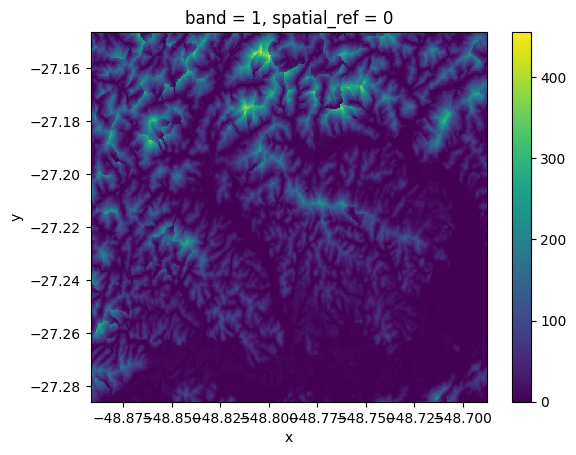

In [36]:
hand = hand.where(hand.data>=0)
hand.plot.imshow()

In [37]:
hand

<xarray.DataArray (y: 517, x: 758)>
array([[54.931946  , 26.370384  , 28.569695  , ..., 64.031525  ,
        67.95157   , 65.21686   ],
       [57.104286  , 32.36522   , 36.418976  , ..., 73.38965   ,
        74.02426   , 71.78284   ],
       [59.514076  , 67.9507    , 44.548233  , ..., 77.90851   ,
        77.92395   , 76.64661   ],
       ...,
       [69.27353   , 66.3139    , 64.29848   , ...,  0.5395236 ,
         0.56625414,  0.49318886],
       [69.929245  , 67.03255   , 63.779453  , ...,  0.31868052,
         0.27028465,  0.28684354],
       [69.929245  , 67.19518   , 62.19361   , ...,  0.26928473,
         0.430367  ,  0.47552466]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -48.89 -48.89 -48.89 ... -48.69 -48.69 -48.69
  * y            (y) float64 -27.15 -27.15 -27.15 ... -27.29 -27.29 -27.29
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768.0
    scale_factor:   1.0
    add_offset:     0.0

## Open ANADEM

In [38]:
anadem = xrio.open_rasterio('/data/anadem_pitless.tif').squeeze()
anadem = anadem.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

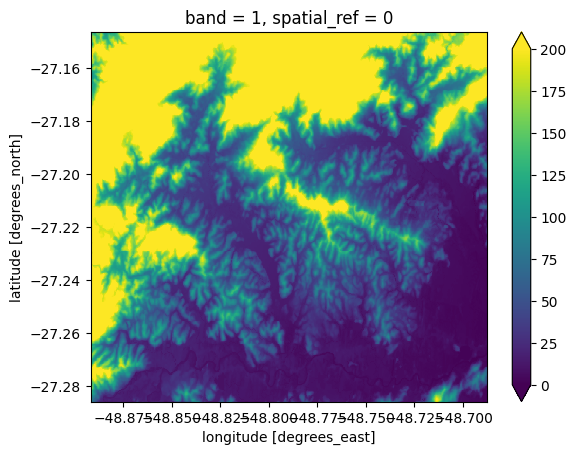

In [53]:
anadem.plot.imshow(vmin=0, vmax=200)

## Project DEM and FLOOD to the same shape

In [40]:
import skimage
import numpy as np

In [41]:
max_flood = max_flood.astype('int').rio.reproject(dst_crs='epsg:4326', shape=dem.shape)
hand = hand.rio.reproject(dst_crs='epsg:4326', shape=dem.shape)
anadem = anadem.rio.reproject(dst_crs='epsg:4326', shape=dem.shape)

In [42]:
def flood_areas(flood_mask, dem, threshold=25):
    """Extrapolate the flood according to the DEM of the area"""

    # first, we clean the area by removing very small regions
    flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=threshold)

    # isolate all the identified flood areas
    labels = skimage.measure.label(flood_mask)
    print(f'Number of areas to flood: {labels.max()}')

    # create a list to store the floods
    floods = []
    dem_steps = []
    for label in tqdm(range(1, labels.max()+1)):
        print(f'Processing label {label}')

        # get the flood for the corresponding label (area)
        # and set all other pixels to 0
        flood_step = labels.copy()
        flood_step[labels!=label] = 0

        # get the highest pixel within the area, but try to remove any outlier
        height = np.percentile(dem[labels==label], 90)
        # height = dem[labels==label].max()
        print(f'Height={height}')

        # create a the DEM-fences with the calculated height
        dem_step = dem.copy()
        dem_step[dem_step<=height] = 0
        dem_step[dem_step>height] = 1

        dem_steps.append(dem_step)

        # to flood-fill, we need a starting point, we can get the lowest point with the label
        xs, ys = np.where(labels==label)
        pos = dem[xs, ys].argmin()
        start = (xs[pos], ys[pos])

        # flood fill and get the extended flood for this label
        flood = skimage.morphology.flood_fill(dem_step, seed_point=start, new_value=-1)
        flood = np.where(flood==-1, 1, 0)
        floods.append(flood)

    return floods, labels, dem_steps
        

In [43]:
def flood_areas_hand(flood_mask, dem, hand, threshold=50):
    """Extrapolate the obtained flood mask according to the DEM and HAND of the area"""

    # first, we clean the area by removing very small regions
    flood_mask = skimage.morphology.area_opening(flood_mask, area_threshold=threshold)

    # isolate all the identified flood areas
    labels = skimage.measure.label(flood_mask)
    print(f'Number of areas to flood: {labels.max()}')

    # create lists to store the floods for each label and the dem region for each label
    floods = []
    dem_steps = []

    # let's loop through each label (i.e., flood region)
    for label in tqdm(range(1, labels.max()+1)):
        print(f'Processing label {label}')

        # get the flood for the corresponding label (area)
        # and set all other pixels to 0
        flood_step = labels.copy()
        flood_step[labels!=label] = 0

        # get the highest pixel within the area, but try to remove any outlier
        height = np.percentile(dem[labels==label], 95)
        # height = dem[labels==label].max()
        print(f'Height={height}')

        # create a the DEM-fences with the calculated height
        # this guarantees the flood fill will not go uphill and will not cross boundaries
        dem_step = dem.copy()
        dem_step[dem_step<=height] = 0
        dem_step[dem_step>height] = 1


        # the problem with the last assumption is that the river goes down so the farthest from the fill point
        # a bigger area will be flooded. In this case, we add a second assumption considering the HAND value
        hand_height = np.percentile(hand[labels==label], 95)
        if not np.isnan(hand_height):

            print(f'Hand height = {hand_height}')
            # dem_step[hand <= hand_height] = 0
            dem_step[hand > hand_height] = 1

            dem_steps.append(dem_step)

            # to flood-fill, we need a starting point, we can get the lowest point with the label
            xs, ys = np.where(labels==label)
            pos = dem[xs, ys].argmin()
            start = (xs[pos], ys[pos])

            # flood fill and get the extended flood for this label
            flood = skimage.morphology.flood_fill(dem_step, seed_point=start, new_value=-1)
            flood = np.where(flood==-1, 1, 0)

        else:
            print(f'No hand available')
            flood = np.where(labels == label, 1, 0)
            dem_steps.append(flood)

        floods.append(flood)

    return floods, labels, dem_steps, hand_height

In [63]:
flooded_regions, labels, dem_steps, hand_height = flood_areas_hand(max_flood.data, anadem.data, hand.data.squeeze(), threshold=50)

Number of areas to flood: 0


0it [00:00, ?it/s]

UnboundLocalError: local variable 'hand_height' referenced before assignment

In [55]:
# dem.rio.to_raster('/data/tmp/dem.tif')

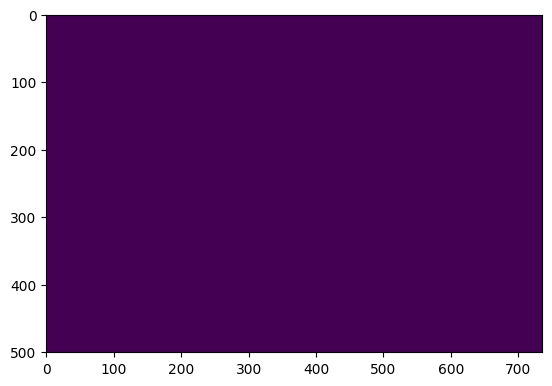

In [56]:
label = 13
plt.imshow(labels==label)

In [57]:
plt.imshow(dem_steps[label-1])

IndexError: list index out of range

In [58]:
plt.imshow(flooded_regions[label-1])

IndexError: list index out of range

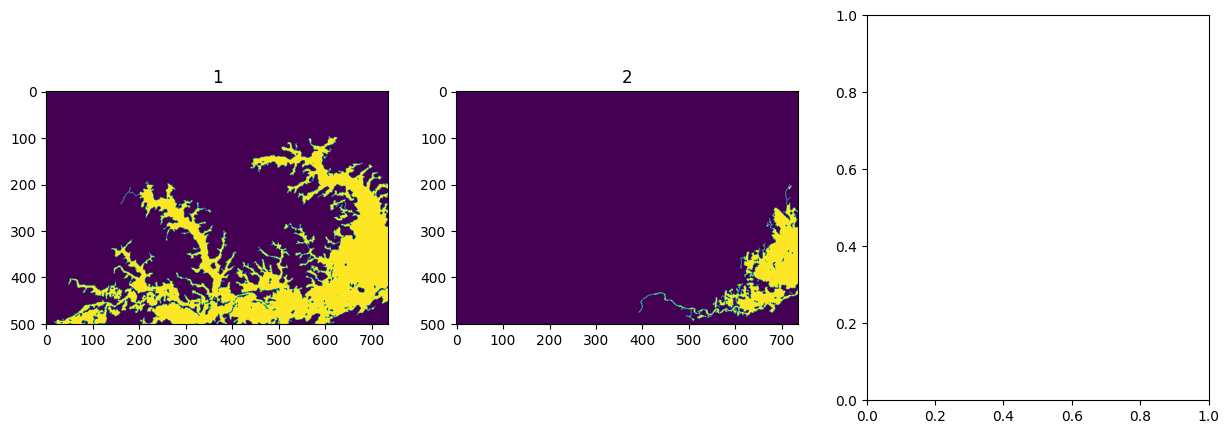

In [59]:
import math 

n = len(flooded_regions)
cols = 3
rows = math.ceil(n/cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
for i in range(n):
    ax = axs.reshape(-1)[i]
    ax.set_title(i+1)
    ax.imshow(flooded_regions[i])


In [60]:
# create final mask
# concatenate the floods into a cube
floods_cube = np.stack(flooded_regions)

extrapolated_flood = max_flood.copy()
extrapolated_flood.data = floods_cube.any(axis=0)

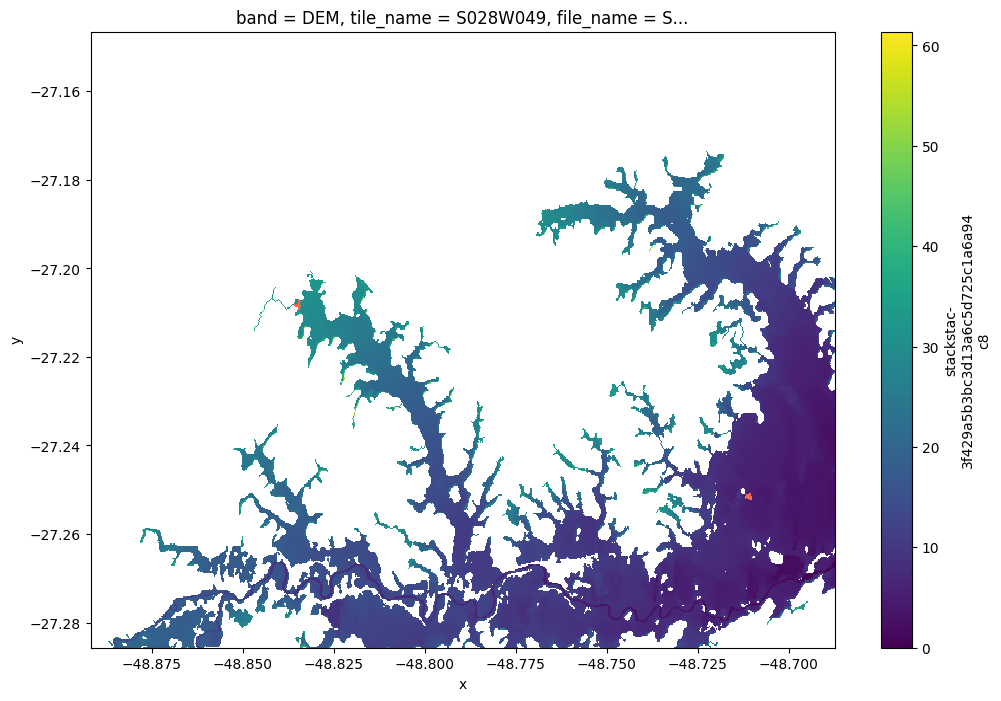

In [164]:
ax = aoi.plot(zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
dem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
# dem.where(dem < flood_height).plot(zorder=0)
labels_spatial = dem.copy()
labels_spatial.data = labels > 0

labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', vmax=1, add_colorbar=False)


In [44]:
# Option 2: Without HAND
flooded_regions, labels, dem_steps = flood_areas(max_flood.data, anadem.data, threshold=10)

Number of areas to flood: 14


  0%|          | 0/14 [00:00<?, ?it/s]

Processing label 1
Height=14.0
Processing label 2
Height=15.759986400604248
Processing label 3
Height=19.18462219238281
Processing label 4
Height=20.764114379882812
Processing label 5
Height=18.063724517822266
Processing label 6
Height=19.393125915527342
Processing label 7
Height=17.755168914794922
Processing label 8
Height=21.63644027709961
Processing label 9
Height=22.36024971008301
Processing label 10
Height=17.987197875976562
Processing label 11
Height=20.03740997314453
Processing label 12
Height=14.049631118774414
Processing label 13
Height=22.269595527648924
Processing label 14
Height=22.945754432678225


In [45]:
# create final mask
# concatenate the floods into a cube
floods_cube = np.stack(flooded_regions)

extrapolated_flood = max_flood.copy()
extrapolated_flood.data = floods_cube.any(axis=0)

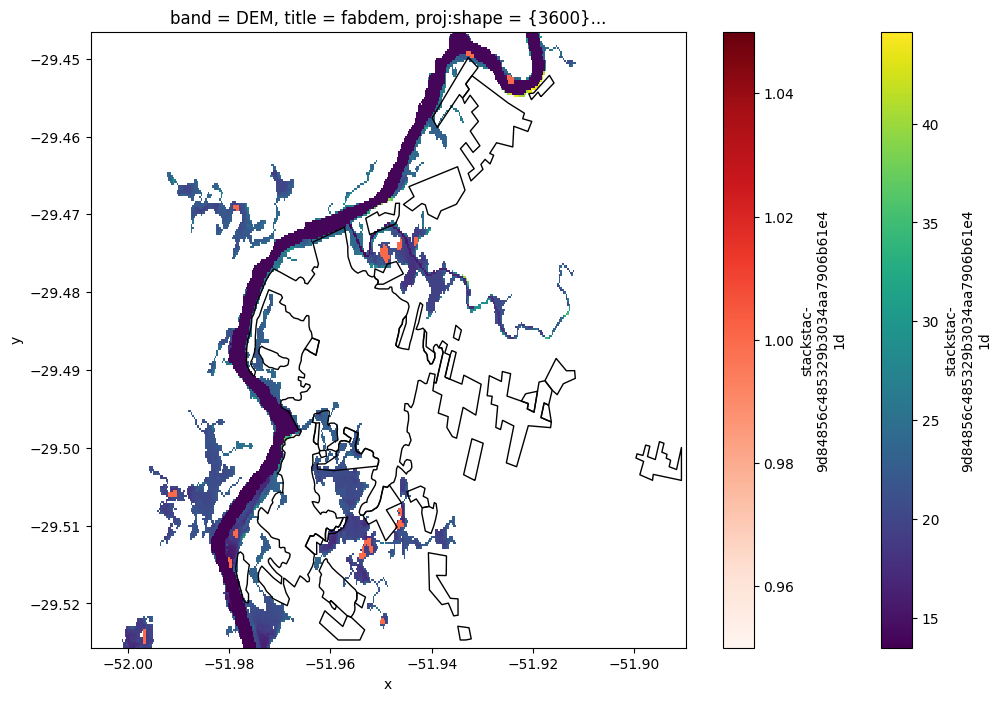

In [46]:
ax = aoi.plot(zorder=1, figsize=(12,8), facecolor='none', edgecolor='black')
dem.where(extrapolated_flood.data==1).plot.imshow(ax=ax)
# dem.where(dem < flood_height).plot(zorder=0)
labels_spatial = dem.copy()
labels_spatial.data = labels > 0

labels_spatial.where(labels_spatial.data == True).plot.imshow(ax=ax, cmap='Reds', vmax=1)


In [319]:
dem.where(extrapolated_flood.data==1).rio.to_raster('/data/tmp/extrapolated_flood.tif')


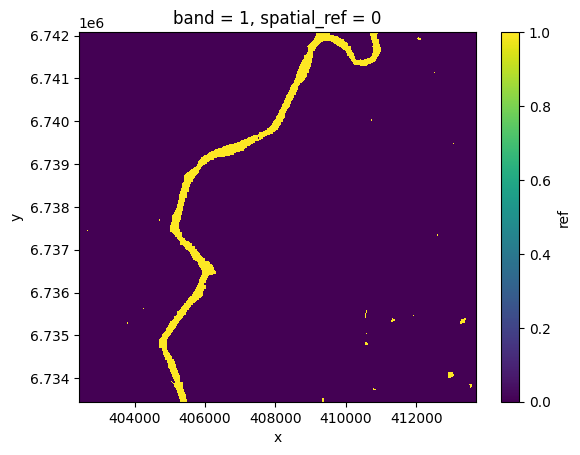

In [48]:
floods['ref'].plot.imshow()

In [141]:
flood_regions_stack = np.stack(flooded_regions)

In [142]:
flood_regions_stack.sum(axis=(1, 2))

array([320145, 322211, 321758, 320320, 321940, 321014, 319009, 321841,
       314249, 318542, 319495, 320563, 317213, 312543, 319196, 312014,
       307220, 312463, 302139, 319624, 301433])

In [63]:
flood_regions_stack.shape

(59, 469, 694)

In [64]:
len(flooded_regions)

59

In [82]:
np.percentile?

Signature:      
np.percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    method='linear',
    keepdims=False,
    *,
    interpolation=None,
)
Call signature:  np.percentile(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function percentile at 0x7f09ac24f490>
File:            /usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py
Docstring:      
Compute the q-th percentile of the data along the specified axis.

Returns the q-th percentile(s) of the array elements.

Parameters
----------
a : array_like of real numbers
    Input array or object that can be converted to an array.
q : array_like of float
    Percentage or sequence of percentages for the percentiles to compute.
    Values must be between 0 and 100 inclusive.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the percentiles are computed. The
    default is to compute the percentile(s) along a flattened
    version of the array.
